In [1]:
cd /home/disk2/wdd/PDZ/MSM/amberff03ws/

/home/disk2/wdd/PDZ/MSM/amberff03ws


In [2]:
from msmbuilder.dataset import dataset
from msmbuilder.cluster import KCenters
from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.cluster import MiniBatchKMedoids
from msmbuilder.msm import MarkovStateModel
from msmbuilder.lumping import PCCAPlus
from msmbuilder.lumping import PCCA
from msmbuilder.msm import implied_timescales
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
font_path = '/home/disk2/wdd/msm/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=20)

/software/anaconda2/envs/msmb/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/software/anaconda2/envs/msmb/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
xyz = dataset("./*.xtc",topology='cry.pdb',stride=1)

In [4]:
from msmbuilder.featurizer import DihedralFeaturizer
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = xyz.fit_transform_with(featurizer, 'diheds/', fmt='dir-npy')
from msmbuilder.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_diheds = diheds.fit_transform_with(scaler, 'scaled_diheds/', fmt='dir-npy')


In [33]:
from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=40, n_components=4)
# fit and transform can be done in seperate steps:
tica_model = scaled_diheds.fit_with(tica_model)
tica_trajs = scaled_diheds.transform_with(tica_model, 'ticas40/', fmt='dir-npy')

In [34]:
clusterer = MiniBatchKMedoids(n_clusters=900, random_state=42)
clustered_trajs = tica_trajs.fit_transform_with(
    clusterer, 'kmedoids900_tica40/', fmt='dir-npy'
)

In [35]:
lag_times = np.arange(1,200,5)
n_timescales = 20
msm_timescales = implied_timescales(clustered_trajs, lag_times, n_timescales=n_timescales, msm=MarkovStateModel(verbose=False), n_jobs = 5)

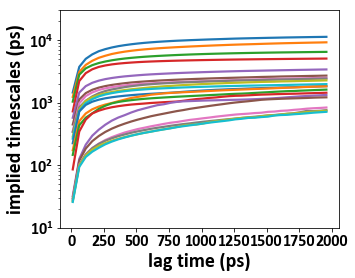

In [36]:
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(1,1,1)
for i in range(n_timescales):
    plt.plot(lag_times*10, msm_timescales[:,i]*10,lw=2.2)
for label in (sub.get_xticklabels() + sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(16)
plt.xlabel(r'lag time (ps)',fontproperties=font_prop)
plt.ylabel(r'implied timescales (ps)',fontproperties=font_prop)
plt.ylim(10,30000)
plt.semilogy()
plt.savefig('impliedtimescales_kmedoids900_tica40_dihed.png',dpi=600,bbox_inches='tight')
plt.show()

In [37]:
msm=MarkovStateModel(lag_time=80,reversible_type='mle', verbose=False)
msm.fit(clustered_trajs)
lab_fix=msm.transform(clustered_trajs,mode='fill')

In [21]:
mkdir ../micro800_lag80_dihed

In [38]:
cd /home/disk2/wdd/PDZ/MSM/amberff03ws/micro900_tica40_lag80_dihed

/home/disk2/wdd/PDZ/MSM/amberff03ws/micro900_tica40_lag80_dihed


In [39]:
wf=open('Populations.dat','w')
for h in msm.populations_:
    wf.write(str(h)+'\n')
wf.close()

matrix = msm.transmat_
wf=open('matrix.dat','w')
for h in matrix:
    for l in h:
        wf.write(str(l)+'    ')
    wf.write('\n')
wf.close()

In [40]:
cp -r ../kmedoids900_tica40/ ./

In [41]:
import mdtraj.io as mdio
from msmbuilder.io import save_meta,load_meta
save_meta(clustered_trajs,'clustered_trajs.pickl')
save_meta(msm,'msm.pickl')

In [18]:
/home/disk2/wdd/glpf/msm/CKtestV5 -msm msm.pickl -clu clustered_trajs.pickl -dt 10 -T 5

In [81]:
cd /home/disk2/wdd/PDZ/MSM/amberff03ws/micro900_tica40_lag80_dihed/macro15/

/home/disk2/wdd/PDZ/MSM/amberff03ws/micro900_tica40_lag80_dihed/macro15


In [73]:
nMacrostates = 15
lagT = 80
pcca = PCCAPlus.from_msm(msm, n_macrostates=nMacrostates)
macro_trajs = pcca.transform(lab_fix)

Optimization terminated successfully.
         Current function value: -10.479930
         Iterations: 14
         Function evaluations: 1393


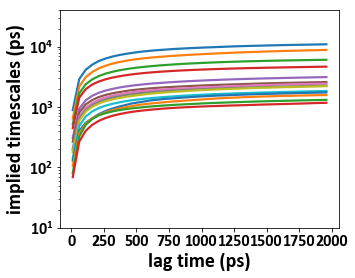

In [79]:
lag_times = np.arange(1,200,5)
n_timescales = 14
msm_timescales = implied_timescales(macro_trajs, lag_times, n_timescales=n_timescales, msm=MarkovStateModel(reversible_type='mle',ergodic_cutoff='on',verbose=False), n_jobs = 4)
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(1,1,1)
for i in range(n_timescales):
    plt.plot(lag_times*10, msm_timescales[:,i]*10,lw=2.2)
for label in (sub.get_xticklabels() + sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(16)
plt.xlabel(r'lag time (ps)',fontproperties=font_prop)
plt.ylabel(r'implied timescales (ps)',fontproperties=font_prop)
plt.ylim(10,40000)
plt.semilogy()
plt.savefig('Macro15_impliedtimescales_lag80.png',dpi=600,bbox_inches='tight')
plt.show()

In [80]:
Macromsm = MarkovStateModel(lag_time=80,ergodic_cutoff='on',reversible_type=None)
Macromsm.fit(macro_trajs)

MSM contains 1 strongly connected component above weight=0.01. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=80, n_timescales=None,
         prior_counts=0, reversible_type=None, sliding_window=True,
         verbose=True)

In [82]:
wf=open('Macro_Population.dat','w')
for h in Macromsm.populations_:
    wf.write(str(float(h))+'\n')
wf.close()
from msmbuilder.tpt import mfpts
Macro_mfpt = mfpts(Macromsm)
wf=open('Macro_mfpt.dat','w')
for h in Macro_mfpt:
    for l in h:
        wf.write(str(l)+'    ')
    wf.write('\n')
wf.close()
wf=open('tProb.mtx','w')
wf.write('%%MatrixMarket matrix coordinate real general\n%\n')
wf.write(str(len(Macromsm.transmat_))+' '+str(len(Macromsm.transmat_[0]))+' '+str(len(Macromsm.transmat_)*len(Macromsm.transmat_[0]))+'\n')
for i in range(len(Macromsm.transmat_)):
    for j in range(len(Macromsm.transmat_[i])):
        wf.write(str(i+1)+' '+str(j+1)+' '+str(Macromsm.transmat_[i][j])+'\n')
wf.close()

In [55]:
pwd

u'/home/disk2/wdd/PDZ/MSM/amberff03ws/micro900_tica40_lag80_dihed'

In [83]:
save_meta(Macromsm,'Macromsm.pickl')

In [84]:
save_meta(macro_trajs,'macro_trajs.pickl')

In [85]:
from msmbuilder.tpt import hub_scores
hubscore=hub_scores(Macromsm)

In [86]:
hubscore

array([ 0.06848489,  0.17014346,  0.20683091,  0.16993023,  0.23085338,
        0.20528997,  0.30785327,  0.27476037,  0.2039564 ,  0.3890058 ,
        0.53104383,  0.41469266,  0.57177569,  0.61631988,  0.63950472])

In [87]:
wf=open('Macro15_hubScores.dat','w')
for h in hubscore:
    wf.write(str(h)+'\n')
wf.close()

In [88]:
wf=open('xtc_sortname.cs','w')
for i in range(len(xyz)):
    wf.write(str(xyz.filename(i))+'\n')
wf.close()

In [91]:
cd /home/disk2/wdd/PDZ/MSM/amberff03ws/micro900_tica40_lag80_dihed/macro25/temp

/home/disk2/wdd/PDZ/MSM/amberff03ws/micro900_tica40_lag80_dihed/macro25/temp


In [59]:
xyz_trj = dataset("./*_sample.xtc",topology='cry.pdb',stride=1)
featurizer_s = DihedralFeaturizer(types=['phi', 'psi'],sincos=False)
diheds_s = xyz_trj.fit_transform_with(featurizer_s, 'diheds_s/',fmt='dir-npy')

In [64]:
xyz_c = dataset("./crystal.pdb",topology='crystal.pdb',stride=1)
featurizer_c = DihedralFeaturizer(types=['phi', 'psi'],sincos=False)
diheds_c = xyz_c.fit_transform_with(featurizer_c, 'diheds_c/',fmt='dir-npy')

In [65]:
crystral_dihed=diheds_c[0][0]/3.14*180

In [89]:
def singleSD(nList,refList):
    length=len(nList)
    sumVar=0.0
    for i in range(length):
        sub=nList[i]-refList[i]
        if np.abs(sub)>180:
            sub=360-np.abs(sub)
        sumVar+=sub**2
    return ((float(sumVar)/float((length)))**0.5)

In [90]:
crystral_dihed

array([ -60.02958679, -139.56974792, -129.19688416,  -89.59128571,
       -128.53622437,  148.59483337,  129.79824829,  135.33282471,
        132.82144165], dtype=float32)

In [92]:
# rmsd of dihedral angle
wf=open('rmsd_dihed.cs','w')
for i in range(25):
    allRmsd=0
    for j in range(len(diheds_s[i])):
        rmsd=singleSD(diheds_s[i][j]/3.14*180,crystral_dihed)
        allRmsd+=rmsd
    aveRmsd=allRmsd/float(len(diheds_s[i]))
    wf.write(str(i)+'    '+str(aveRmsd)+'\n')
wf.close()

In [68]:
#save dihedral angle
for i in range(25):
    wf=open(str(i)+'_dihed.cs','w')
    for j in range(len(diheds_s[i])):
        for k in range(len(diheds_s[i][j])):
            wf.write(str(diheds_s[i][j][k]/3.14*180)+'    ')
        wf.write('\n')
    wf.close()

In [74]:
pwd

u'/home/disk2/wdd/PDZ/MSM/amberff03ws/micro900_tica40_lag80_dihed/macro25/temp'

In [94]:
cd /home/disk2/wdd/PDZ/MSM/amberff03ws/micro900_tica40_lag80_dihed/macro15/temp

/home/disk2/wdd/PDZ/MSM/amberff03ws/micro900_tica40_lag80_dihed/macro15/temp


In [95]:
xyz_trj = dataset("./*_sample.xtc",topology='cry.pdb',stride=1)
featurizer_s = DihedralFeaturizer(types=['phi', 'psi'],sincos=False)
diheds_s = xyz_trj.fit_transform_with(featurizer_s, 'diheds_s/',fmt='dir-npy')

In [97]:
xyz_c = dataset("./crystal.pdb",topology='crystal.pdb',stride=1)
featurizer_c = DihedralFeaturizer(types=['phi', 'psi'],sincos=False)
diheds_c = xyz_c.fit_transform_with(featurizer_c, 'diheds_c/',fmt='dir-npy')

In [98]:
crystral_dihed=diheds_c[0][0]/3.14*180

In [100]:
# rmsd of dihedral angle
wf=open('rmsd_dihed.cs','w')
for i in range(15):
    allRmsd=0
    for j in range(len(diheds_s[i])):
        rmsd=singleSD(diheds_s[i][j]/3.14*180,crystral_dihed)
        allRmsd+=rmsd
    aveRmsd=allRmsd/float(len(diheds_s[i]))
    wf.write(str(i)+'    '+str(aveRmsd)+'\n')
wf.close()